# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

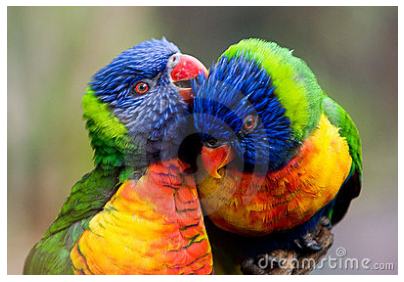

In [70]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [71]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [72]:
from sklearn.cluster import KMeans
import numpy as np
from skimage.metrics import structural_similarity as ssim

def k_means(model, img):
    img = img.reshape((-1, 3))
    #model = model(n_clusters=n_clusters)
    model.fit(img)
    cluster_list = model.cluster_centers_.tolist()
    img_pred = model.predict(img)
    img_pred = img_pred.tolist()
    for i in range(len(img_pred)):
        cluster = img_pred[i]
        img_pred[i] = list(cluster_list[cluster])
    draw_picture(np.array(img_pred, dtype='uint8').reshape(275, 400, 3))
    return ssim(img.reshape(275, 400, 3), np.array(img_pred, dtype='uint8').reshape(275, 400, 3), multichannel=True)


### K-Means

Число кластеров:  2


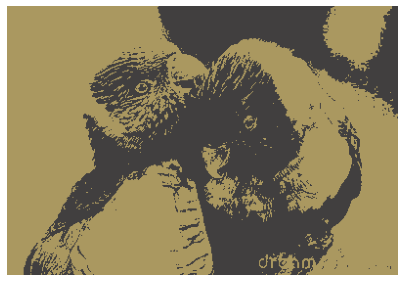

SSIM  при 2 кластерах (1 - потери от уменьшения цветов): 0.5334602317209814
Число кластеров:  3


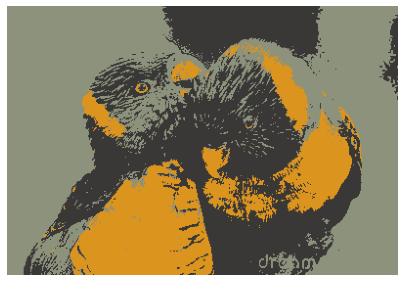

SSIM  при 3 кластерах (1 - потери от уменьшения цветов): 0.5634941476611567
Число кластеров:  5


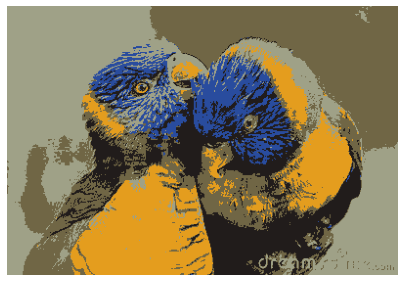

SSIM  при 5 кластерах (1 - потери от уменьшения цветов): 0.6251293996787776
Число кластеров:  10


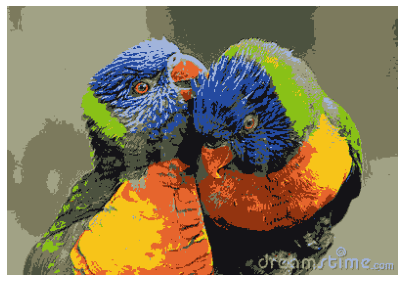

SSIM  при 10 кластерах (1 - потери от уменьшения цветов): 0.6791073112669251
Число кластеров:  20


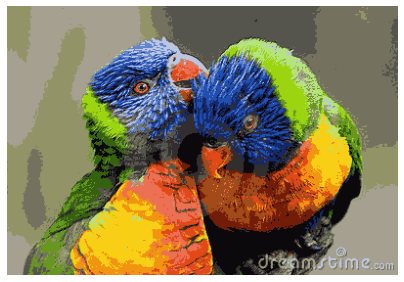

SSIM  при 20 кластерах (1 - потери от уменьшения цветов): 0.7592991297344693


In [73]:
errors_list = []
n_clusters_list = [2, 3, 5, 10, 20]
for i in n_clusters_list:
    print('Число кластеров: ', i)
    error = k_means(KMeans(n_clusters=i), img)
    errors_list.append(error)
    print(f'SSIM  при {i} кластерах (1 - потери от уменьшения цветов): {error}')
    

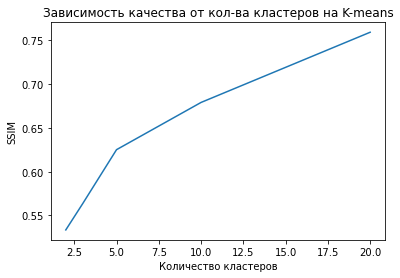

In [74]:
import matplotlib.pyplot as plt

plt.plot(n_clusters_list, errors_list)
plt.xlabel('Количество кластеров')
plt.ylabel('SSIM')
plt.title("Зависимость качества от кол-ва кластеров на K-means")
plt.show()

### DBSCAN

 Здесь у меня возникли некоторые проблемы. (Некоторым цветам которые были в словаре, 
выдаваемым моделью, не присваивались никакие координаты. Список для этих цветов оставался пустой. Я долго решал эту проблему
но не решил. Поэтому заполнил такие точки чёрным цветом.)

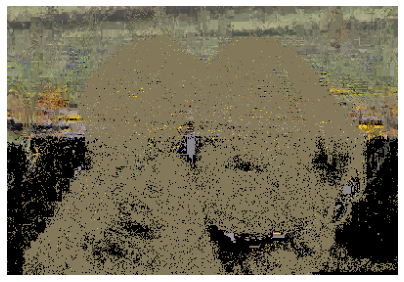

eps=0.3, min_samples=2, количество цветов = 10527
SSIM: 0.09260427870122995


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


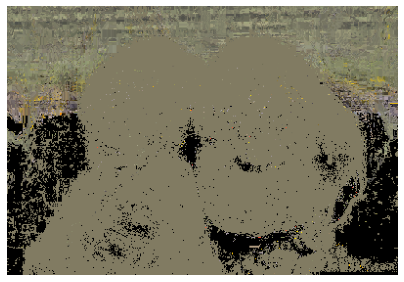

eps=0.3, min_samples=3, количество цветов = 5732
SSIM: 0.11754391839354643


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


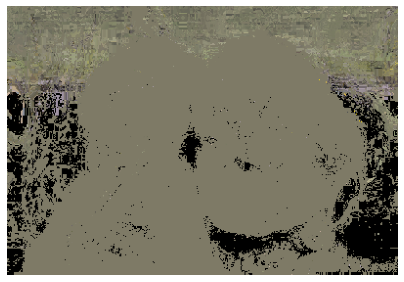

eps=0.3, min_samples=5, количество цветов = 3210
SSIM: 0.14302984716819858


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


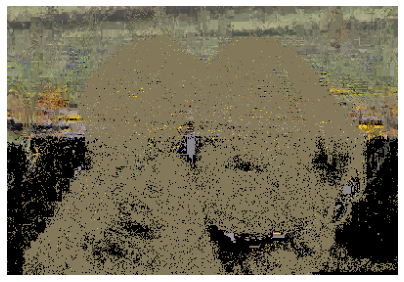

eps=0.5, min_samples=2, количество цветов = 10527
SSIM: 0.09260427870122995


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


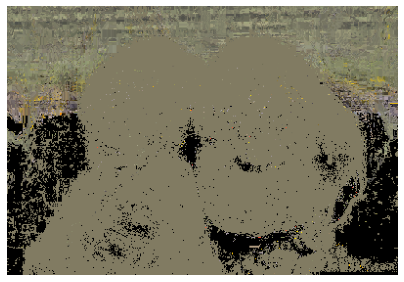

eps=0.5, min_samples=3, количество цветов = 5732
SSIM: 0.11754391839354643


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


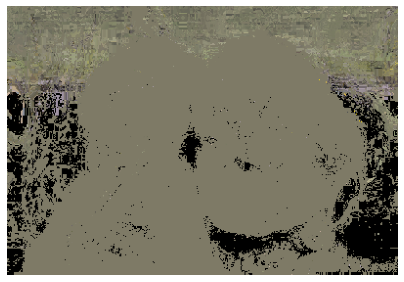

eps=0.5, min_samples=5, количество цветов = 3210
SSIM: 0.14302984716819858


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


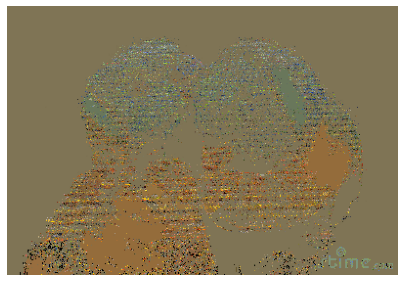

eps=3, min_samples=2, количество цветов = 5613
SSIM: 0.3770867320852213


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


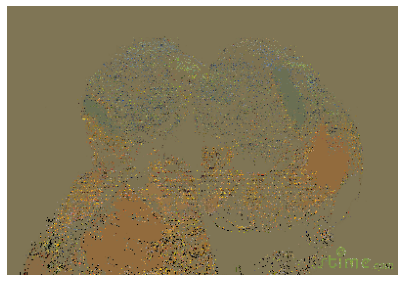

eps=3, min_samples=3, количество цветов = 2543
SSIM: 0.3771569897788942


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


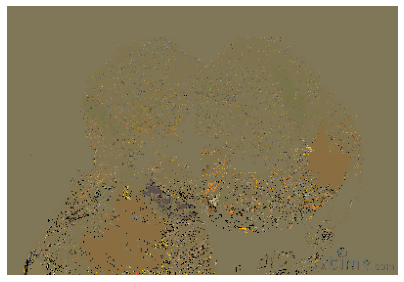

eps=3, min_samples=5, количество цветов = 977
SSIM: 0.37822198894121084


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


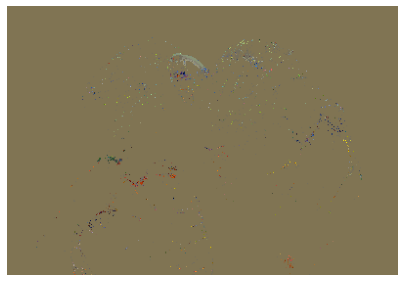

eps=7, min_samples=2, количество цветов = 441
SSIM: 0.4047606930951751


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


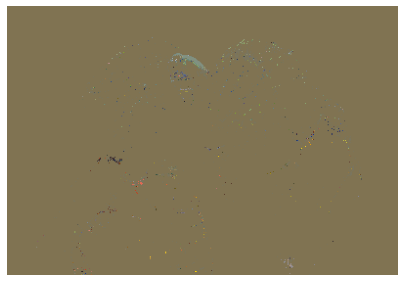

eps=7, min_samples=3, количество цветов = 183
SSIM: 0.40701677043136836


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


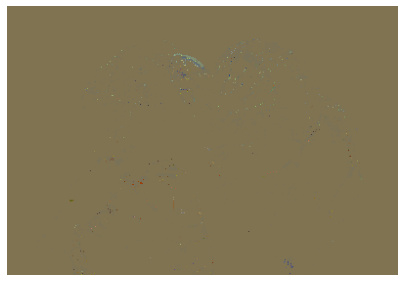

eps=7, min_samples=5, количество цветов = 86
SSIM: 0.40684589122131704


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


In [13]:
from sklearn.cluster import DBSCAN
from collections import Counter

img = cv2.imread('birds.jpg')

for eps in [0.3, 0.5, 3, 7]:
    for min_samples in [2, 3, 5]:
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(img.reshape((-1, 3)))
        img_pred = clustering.fit_predict(img.reshape((-1, 3)))
        # Насколько я понимаю, DBSCAN просто разделяет на кластеры. Он не даёт нам информация о центрах этих кластеров. 
        #Поэтому ниже я сам это выясняю, для того, чтобы определить, каким цветом закрасить этот кластер
        cluster_inv_index = {i: [] for i in Counter(clustering.labels_).keys()}
        for i in range(len(clustering.components_)):
            cluster_inv_index[clustering.labels_[i]].append(clustering.components_[i].tolist())
        res = {k: np.round(np.mean(v, axis=0)).astype('int') if np.array(v).ndim != 1
               else [0, 0, 0] for k, v in cluster_inv_index.items()}
        new_img = np.array([res[i] for i in clustering.labels_])
        draw_picture(new_img.reshape(275, 400, 3))
        print(f'eps={eps}, min_samples={min_samples}, количество цветов = {len(Counter(img_pred.tolist()))}')
        print('SSIM:', ssim(img.reshape(275, 400, 3), new_img.reshape(275, 400, 3), multichannel=True))

### Агломеративная кластеризация

Сначала она не хотела работать. Пришлось сжать картинку

In [75]:
from PIL import Image
foo = Image.open("birds.jpg")
foo = foo.resize((100,64),Image.ANTIALIAS)
foo.save("birds_min.jpg",optimize=True,quality=95)

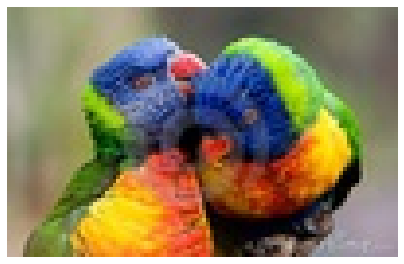

In [76]:
min_img = cv2.imread('birds_min.jpg') 
draw_picture(min_img)

Число кластеров:  2


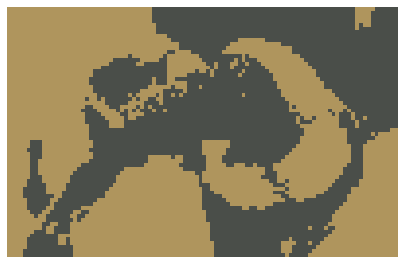

C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


SSIM  при 2 кластерах (1 - потери от уменьшения цветов): 0.46172587657655545
Число кластеров:  3


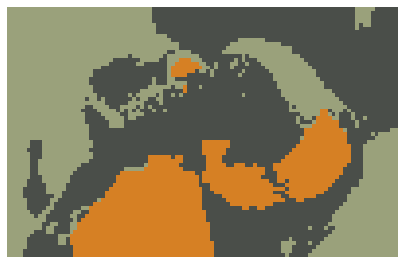

C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


SSIM  при 3 кластерах (1 - потери от уменьшения цветов): 0.4772816398646156
Число кластеров:  5


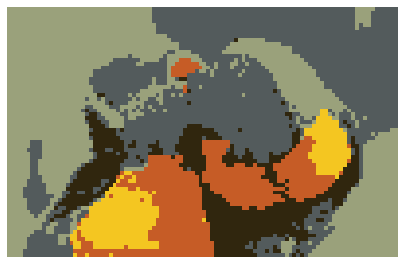

C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


SSIM  при 5 кластерах (1 - потери от уменьшения цветов): 0.5712333196191203
Число кластеров:  10


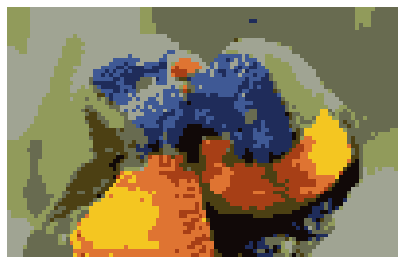

C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


SSIM  при 10 кластерах (1 - потери от уменьшения цветов): 0.7059974582455236
Число кластеров:  20


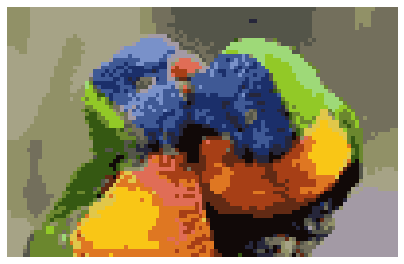

SSIM  при 20 кластерах (1 - потери от уменьшения цветов): 0.7753140216836852


C:\Users\alexe\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


In [79]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

errors_list = []
n_clusters_list = [2, 3, 5, 10, 20]

for i in n_clusters_list:
    print('Число кластеров: ', i)
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(min_img.reshape(-1, 3))
    clf = NearestCentroid()
    clf.fit(min_img.reshape(-1, 3), model.labels_)
    res = model.labels_.tolist()
    for j in range(len(res)):
        res[j] = clf.centroids_[res[j]]
    draw_picture(np.array(res).astype('int').reshape(64, 100, 3))
    error = ssim(min_img.reshape(64, 100, 3), np.array(res).astype('int').reshape(64, 100, 3), multichannel=True)
    errors_list.append(error)
    print(f'SSIM  при {i} кластерах (1 - потери от уменьшения цветов): {error}')
    

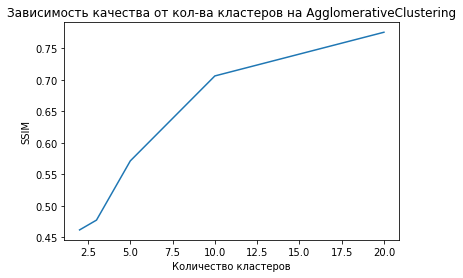

In [80]:
import matplotlib.pyplot as plt

plt.plot(n_clusters_list, errors_list)
plt.xlabel('Количество кластеров')
plt.ylabel('SSIM')
plt.title("Зависимость качества от кол-ва кластеров на AgglomerativeClustering")
plt.show()

Вывод:
* лучше всех справляется K-Means (и бычстро, и хорошее качество). Этот алгоритм при каждом увеличении кол-ва цветов на 1 как бы понимает, какой цвет в данный момент наиболее важный для восстановления качества. 
* Картинки, получившиеся в результате DBSCAN совсем плохие (маленький SSIM), однако этот алгоритм хорошо отделил самих попугаев от фона (это кстати у K-Means  получилось не очень хорошо. 
* Агломеративная кластеризация на метрике показала такой же результат, как и K-Means, однако для реализации этого алгоритма понадобилось сжать картинку. (но он всё равно работал дольше)

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [31]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [273]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [25]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [26]:
y.shape

(2370,)

In [27]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

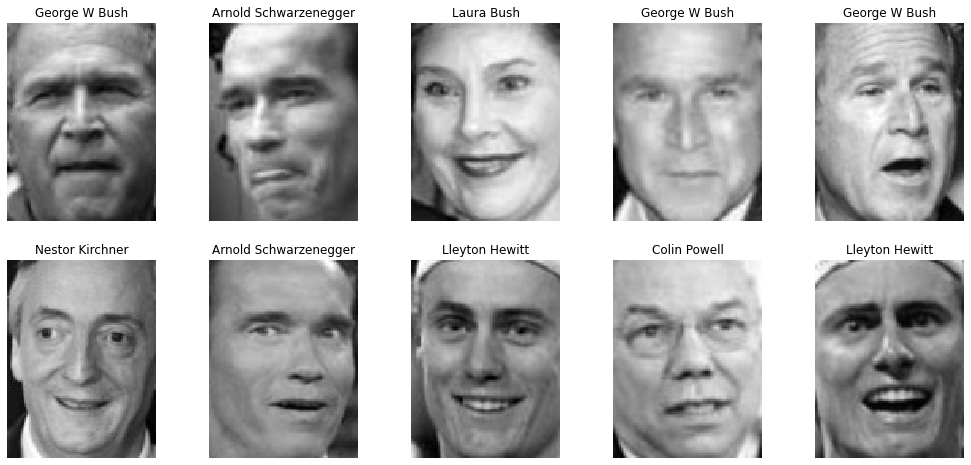

In [96]:
import matplotlib.pyplot as plt
def plot_image(image_id, title=None):
    # функция рисует изображение номер image_id
    if title == None:
        plt.title(names[y[image_id]])
    else:
        plt.title(f'True name: {names[y[image_id]]}\nPredicted name: {names[title]}')
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols, titles=None):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        if titles != None:
            plot_image(example_id, title=titles[index])
        else:
            plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

### 1. Accuracy без уменьшения размерности 

In [29]:
from sklearn.metrics import accuracy_score

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100)

log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

print('Полученные значения для модели Логистической регрессии:')
print('Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
Accuracy: 0.673


In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('Полученные значения для модели KNN:')
print('Accuracy:', round(accuracy_score(y_test, y_pred_knn), 4))

Полученные значения для модели KNN:
Accuracy: 0.4473


In [98]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)

print('Полученные значения для модели DecisionTree:')
print('Accuracy:', round(accuracy_score(y_test, y_pred_tree), 4))

Полученные значения для модели DecisionTree:
Accuracy: 0.3101


### 2. Accuracy после уменьшения размерности

Лучший результат показала логистическая регрессия поэтому будем применять её для каждого алгоритма уменьшения размерности

In [ ]:
# SVD
from sklearn.decomposition import TruncatedSVD

for i in [50, 100, 200, 400]:
    svd = TruncatedSVD(n_components=i, n_iter=7, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)
    log_reg.fit(X_train_svd, y_train)
    y_pred_logreg = log_reg.predict(X_test_svd)

    print('Полученные значения для модели Логистической регрессии:')
    print(f'n_components={i} Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
n_components=50 Accuracy: 0.6329
Полученные значения для модели Логистической регрессии:
n_components=100 Accuracy: 0.6878


Видим, что уменьшение размерности помогло. Результат улучшился на пару процентов.
При последнем запуске у меня не псчиталось для n_components > 100 (но когда запускалось, там accuracy увеличивался до 70.5%)

In [ ]:
#PCA
from sklearn.decomposition import PCA

for i in [50, 100, 200, 400, 600, 800]:
    pca = PCA(n_components=i, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    log_reg.fit(X_train_pca, y_train)
    y_pred_logreg = log_reg.predict(X_test_pca)

    print('Полученные значения для модели Логистической регрессии:')
    print(f'n_components={i} Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
n_components=50 Accuracy: 0.5928
Полученные значения для модели Логистической регрессии:
n_components=100 Accuracy: 0.5781
Полученные значения для модели Логистической регрессии:
n_components=200 Accuracy: 0.654
Полученные значения для модели Логистической регрессии:
n_components=400 Accuracy: 0.6878


Здесь тоже результат немного улучшился при n_components > 400, но при больших значениях не посчиталось.

В цикле не считалось, а вот отдельно мне удалось подобрать параметр:

In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=900, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
log_reg.fit(X_train_pca, y_train)
y_pred_logreg = log_reg.predict(X_test_pca)

print('Полученные значения для модели Логистической регрессии:')
print(f'n_components={i} Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
n_components=3 Accuracy: 0.7131


### Лучший результат = 0.7131

In [99]:
# TSNE
from sklearn.manifold import TSNE
import numpy as np
# 1. TSNE переводит только в 2 и 3 -мерное пространство 
# 2. У него нет атрибута transform. 
# Поэтому мне пришлось сделать fit_transform на всём X, а потом заново разделить на train и test.

for i in [2, 3]:
    X_embedded = TSNE(n_components=i).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_embedded, y,
                                                test_size=0.2, random_state=42)
    log_reg.fit(X_train, y_train)
    y_pred_logreg = log_reg.predict(X_test)

    print('Полученные значения для модели Логистической регрессии:')
    print(f'n_components={i} Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
n_components=2 Accuracy: 0.2342
Полученные значения для модели Логистической регрессии:
n_components=3 Accuracy: 0.2532


TSNE ожидаемо показал плохой результат, так как он уменьшает только до 2 и 3 измерений, а это очень мало, так как начальное кол-во - 11750

### 3. Сравнение с предсказанием : "Всегда самый популярный класс"

Сначала получим самый популярный класс на y_train

In [61]:
from collections import Counter

sorted_x = sorted(dict(Counter(y_train)).items(), key=lambda kv: kv[1], reverse=True)
sorted_x[0]

(8, 417)

Класс 8 самый частый. (417 раз)

In [67]:
y_pred_const = np.array([8] * len(y_test))
print('Accuracy на константе: ', round(accuracy_score(y_test, y_pred_const), 4))

Accuracy на константе:  0.2384


Accuracy на константе в 3 раза меньше чем у наших моделей. => модель делает значительный прогресс.

### 4. Вывод лиц, на которых алгоритм ошибся


Результаты у SVD и PCA практически одинаковые. Однако PCA работал быстрее => будем использовать его (и по-прежнему логистическую регрессию)

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=900, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
log_reg.fit(X_train_pca, y_train)
y_pred_logreg = log_reg.predict(X_test_pca)

print('Полученные значения для модели Логистической регрессии:')
print(f'n_components={i} Accuracy:', round(accuracy_score(y_test, y_pred_logreg), 4))

Полученные значения для модели Логистической регрессии:
n_components=3 Accuracy: 0.7131


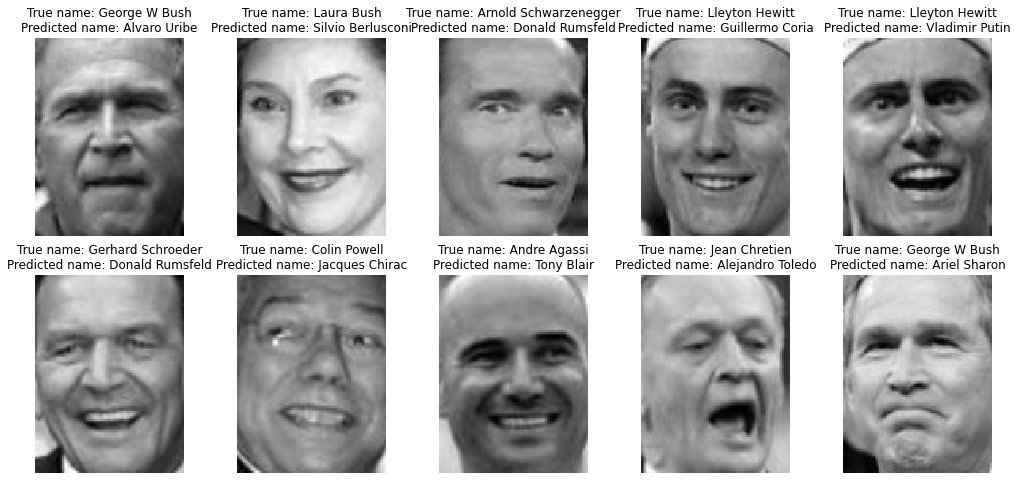

In [98]:
counter = 0
image_ids = []
titles = []
for i in range(len(y_pred_logreg)):
    if y_pred_logreg[i] != y_test[i]:
        image_ids.append(i)
        titles.append(y_pred_logreg[i])
        counter += 1
    if counter > 9:
        break
        
plot_grid(image_ids, nrows=2, ncols=5, titles=titles)

### 5. Визуализация датасета на плоскости 

Я воспользуюсь TSNE, так как главное преимущество этого алгоритма то, что он разносит далеко расположенные точки ещё дальше.
А это хорошо для визуализации.

In [224]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y,
                                                test_size=0.2, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

In [262]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(np.column_stack((X_embedded, y, [names[i] for i in y])))
df[0] = df[0].astype(float)
df[1] = df[1].astype(float)
fig = px.scatter(df, x=1, y=0, color=3)
fig.show()

Мне ещё было интересно посмотреть на визуализацию в трёхмерном пространстве (тоже с TSNE)

Так что вот 

In [275]:
X_embedded = TSNE(n_components=3).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_embedded, y,
                                                test_size=0.2, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)

In [308]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(np.column_stack((X_embedded, y, [names[i] for i in y])))
df = df.drop(index=[1889, 933])
for i in [0, 1, 2]:
    df[i] = df[i].astype(float)
    df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())
df[5] = 1

fig = px.scatter_3d(df, x=1, y=0, z=2, color=4, size=5)
fig.show()
